## **Colab Set Up & Dataset Download**

In this project, we are trying to create a simple implementation of Region based Convolutional Neural Network (RCNN). After training our model, we will use it to detect objects from a video file.

The goal of this project is to create a working RCNN model that detects human. 

There are several important jobs to do:
1. Prepare dataset (i use PASCAL VOC2007. You may use other dataset. One important thing to consider before choosing your dataset is the compatibility with the class you want to detect, how the annotations of the dataset, and how big it is. PASCAL VOC2007 compressed file's size is only 450 MB, and they annotate the images with XML format, which is easy to manipulate with Python.)
2. Set up directory of train and test images (we will use `image_datasets_from_directory` method from TensorFlow 2.3 for training, because it is a lot easier to manage and can supress your memory usage. Make sure to balance each class so the model won't be biased towards one class).
3. Define and train model. I use keras (from tensorflow 2.3) for training. Save the model's weight using checkpoint.
4. Check the result.

If you are satisfied with the result, we can work on the second step: implement object detection in video file.

Before working, connect this Colab with your Google Drive. It will make your file management easier.

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
# go to your workspace. For me, I work on drive/My Drive/Bisa AI/Video Analytcics Bisa AI
%cd ..
%cd 'drive/My Drive/Bisa AI/Video Analytics Bisa AI'

/
/drive/My Drive/Bisa AI/Video Analytics Bisa AI


**Download Dataset**
I use PASCAL VOC2007 dataset for traininng. Download it with `!wget` command to put the compressed file directly to your working directory.

In [4]:
# download
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

--2020-09-11 10:11:21--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  69.6MB/s    in 6.3s    

2020-09-11 10:11:27 (69.3 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [5]:
# untar the file
!tar -xvf VOCtrainval_06-Nov-2007.tar

Output streaming akan dipotong hingga 5000 baris terakhir.
VOCdevkit/VOC2007/JPEGImages/001733.jpg
VOCdevkit/VOC2007/JPEGImages/001734.jpg
VOCdevkit/VOC2007/JPEGImages/001738.jpg
VOCdevkit/VOC2007/JPEGImages/001739.jpg
VOCdevkit/VOC2007/JPEGImages/001741.jpg
VOCdevkit/VOC2007/JPEGImages/001746.jpg
VOCdevkit/VOC2007/JPEGImages/001747.jpg
VOCdevkit/VOC2007/JPEGImages/001749.jpg
VOCdevkit/VOC2007/JPEGImages/001750.jpg
VOCdevkit/VOC2007/JPEGImages/001752.jpg
VOCdevkit/VOC2007/JPEGImages/001754.jpg
VOCdevkit/VOC2007/JPEGImages/001755.jpg
VOCdevkit/VOC2007/JPEGImages/001756.jpg
VOCdevkit/VOC2007/JPEGImages/001758.jpg
VOCdevkit/VOC2007/JPEGImages/001759.jpg
VOCdevkit/VOC2007/JPEGImages/001761.jpg
VOCdevkit/VOC2007/JPEGImages/001765.jpg
VOCdevkit/VOC2007/JPEGImages/001766.jpg
VOCdevkit/VOC2007/JPEGImages/001768.jpg
VOCdevkit/VOC2007/JPEGImages/001771.jpg
VOCdevkit/VOC2007/JPEGImages/001772.jpg
VOCdevkit/VOC2007/JPEGImages/001775.jpg
VOCdevkit/VOC2007/JPEGImages/001777.jpg
VOCdevkit/VOC2007/JPE

## **Import Library and Define Helper Functions**

In [3]:
import os, cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import xml.etree.ElementTree as ET

In [5]:
# set Selective Search.
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
# helper function to get Intersection over Union score.
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## **Preprocessing**

Our second step is to reorganize the dataset. We are trying to make an RCNN model. RCNN is simply a CNN model that utilize a region search method before feeding the image to the CNN model. We will use selective search from OpenCV, so now our remaining task is to create the CNN model. 

We will use a simple method, that is to generate regions from an image using selective search. Then, we will assess each region based on their IoU score with the ground truth. For regions with high IoU score, we assume they are the foreground (or 'person' class that we want to detect), and save the image in another folder with size 224x224. On the contrary, for regions with low IoU score we will save them as background class. Regions with moderate IoU score will be ignored.

In [14]:
# path definition
path = 'VOCdevkit/VOC2007/JPEGImages'
annot = 'VOCdevkit/VOC2007/Annotations'
foreground = 'images/foreground'
background = 'images/background'

In [14]:
for e,i in enumerate(os.listdir(annot)):
  try:
    filename = i.split(".")[0]+".jpg"
    print(e,filename)
    image = cv2.imread(os.path.join(path,filename))
    tree = ET.parse(os.path.join(annot, i))
    root = tree.getroot()
    gtvalues=[]
    # get ground truth boxes
    for obj in root.findall('object'):
      if obj.find('name').text == 'person':
        x1 = int(obj.find('bndbox').find('xmin').text)
        y1 = int(obj.find('bndbox').find('ymin').text)
        x2 = int(obj.find('bndbox').find('xmax').text)
        y2 = int(obj.find('bndbox').find('ymax').text)
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
    # generate regions from each image with selective search
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0
    for e,result in enumerate(ssresults):
        if e < 2000 and flag == 0:
            for gtval in gtvalues:
                x,y,w,h = result
                iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                if counter < 30:
                    if iou > 0.70: # foreground class
                        timage = imout[y:y+h,x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                        cv2.imwrite(os.path.join(foreground, str(counter)+'-'+filename),resized) # save to another directory
                        counter += 1
                else :
                    fflag =1
                if falsecounter <30:
                    if iou < 0.3: # background class
                        timage = imout[y:y+h,x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                        cv2.imwrite(os.path.join(background, str(counter)+'-'+filename),resized) # save to another directory
                        falsecounter += 1
                else :
                    bflag = 1
            if fflag == 1 and bflag == 1:
                print("inside")
                flag = 1
  except Exception as e:
      print(e)
      print("error in "+filename)
      continue

Output streaming akan dipotong hingga 5000 baris terakhir.
65 000134.jpg
66 000138.jpg
67 000140.jpg
68 000141.jpg
69 000142.jpg
70 000143.jpg
71 000146.jpg
72 000147.jpg
73 000150.jpg
74 000153.jpg
75 000154.jpg
76 000156.jpg
77 000158.jpg
78 000159.jpg
79 000161.jpg
80 000162.jpg
81 000163.jpg
82 000164.jpg
83 000165.jpg
84 000169.jpg
85 000170.jpg
86 000171.jpg
87 000173.jpg
88 000174.jpg
89 000177.jpg
90 000180.jpg
91 000184.jpg
92 000187.jpg
93 000189.jpg
94 000190.jpg
95 000192.jpg
96 000193.jpg
97 000194.jpg
98 000198.jpg
99 000200.jpg
100 000203.jpg
101 000207.jpg
102 000208.jpg
103 000209.jpg
104 000210.jpg
105 000211.jpg
106 000214.jpg
107 000215.jpg
108 000218.jpg
109 000219.jpg
110 000220.jpg
111 000221.jpg
112 000222.jpg
113 000224.jpg
114 000225.jpg
115 000228.jpg
116 000229.jpg
117 000232.jpg
118 000233.jpg
119 000235.jpg
120 000236.jpg
121 000241.jpg
122 000242.jpg
123 000244.jpg
124 000245.jpg
125 000246.jpg
126 000249.jpg
127 000250.jpg
128 000251.jpg
129 000256.jpg
1

Then, we check the number of images in each class. We found out that the foreground has 16531 images, while background only has 2182. This unevenly distributed number will cause the model to learn the wrong thing, so we have to pick the same number of images from each class and copy it to another directory. 

In [30]:
print(len(os.listdir(foreground)))
print(len(os.listdir(background)))

16531
2182


In [16]:
import shutil

In [52]:
for i, file in enumerate(os.listdir(background)):
  if i < 1600:
    shutil.copy(os.path.join(background, file), os.path.join('images/train/background', file))
  elif i < 2100:
    shutil.copy(os.path.join(background, file), os.path.join('images/test/background', file))
  else:
    break

In [57]:
for i, file in enumerate(os.listdir(foreground)):
  if i < 1600:
    shutil.copy(os.path.join(foreground, file), os.path.join('images/train/foreground', file))
  elif i < 2100:
    shutil.copy(os.path.join(foreground, file), os.path.join('images/test/foreground', file))
  else:
    break

Now we have 1600 images for training from both classes, and 500 images for test.

In [19]:
print(len(os.listdir('images/train/background')))
print(len(os.listdir('images/train/foreground')))
print(len(os.listdir('images/test/background')))
print(len(os.listdir('images/test/foreground')))

1600
1600
500
500


## **Model Definition (CNN)**

Define the classifier model. For this task, I created simple CNN classifier with VGG backbone and 1 last node as binary classifier. I used ImageNet weight for the VGG16 (feature extractor).

In [7]:
from tensorflow import keras

In [8]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

In [9]:
vggmodel = VGG16(weights='imagenet', include_top = True)

553467904/553467096 [==============================] - 8s 0us/step


In [10]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(vggmodel.input, predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.binary_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Generate the dataset generator using `tf.keras.preprocessing.image_dataset_from_directory`. This method will give you easier interface for training.

In [84]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "images/train",
    validation_split = 0.2,
    subset = "training",
    seed = 0,
    image_size = (224, 224),
    batch_size = 32
)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.


In [85]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "images/test",
    validation_split = 0.2,
    subset = "validation",
    seed = 0,
    image_size = (224, 224),
    batch_size = 32
)

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [86]:
print(train_ds.class_names)
print(val_ds.class_names)

['background', 'foreground']
['background', 'foreground']


In [89]:
callback = tf.keras.callbacks.ModelCheckpoint('checkpoints/{epoch}', save_weights_only=True, save_best_only=True)

**Training**

In [92]:
# start fitting
model_final.fit(train_ds, validation_data = val_ds, epochs = 5, callbacks = [callback])

Epoch 1/5
80/80 [==============================] - 1257s 16s/step - loss: 0.3245 - accuracy: 0.8930 - val_loss: 0.6260 - val_accuracy: 0.8550
Epoch 2/5
80/80 [==============================] - 1243s 16s/step - loss: 0.0915 - accuracy: 0.9699 - val_loss: 1.2128 - val_accuracy: 0.8150
Epoch 3/5
80/80 [==============================] - 1239s 15s/step - loss: 0.0410 - accuracy: 0.9867 - val_loss: 0.9442 - val_accuracy: 0.7800
Epoch 4/5
80/80 [==============================] - 1238s 15s/step - loss: 0.0343 - accuracy: 0.9906 - val_loss: 2.2215 - val_accuracy: 0.7400
Epoch 5/5
80/80 [==============================] - 1236s 15s/step - loss: 0.0442 - accuracy: 0.9879 - val_loss: 0.8010 - val_accuracy: 0.8650


**Weight Loading**

In [11]:
# if you have a trained weight, just load it with load_weights method.
model_final.load_weights('checkpoints/1')

Test your model with some images. It is shown that higher scores correspond to person class, while lower scores correspond with background.

In [12]:
gambar_tes = plt.imread('images/train/foreground/0-000021.jpg')
gambar_tes = np.expand_dims(gambar_tes, axis = 0)
result = model_final.predict(gambar_tes)
print(result)

[[0.99921983]]


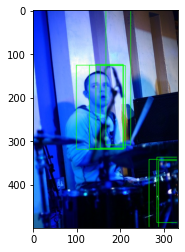

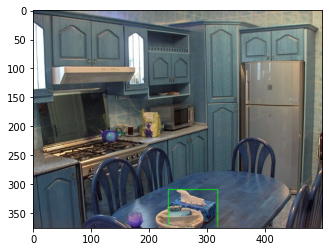

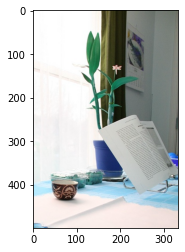

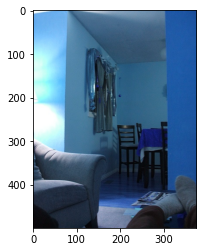

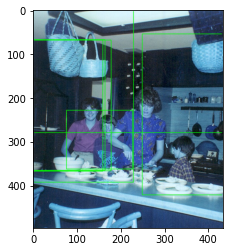

In [20]:
for e, i in enumerate(os.listdir(path)):
  if e < 5:
    img = cv2.imread(os.path.join(path, i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    for ex, result in enumerate(ssresults):
      if ex < 500:
        x, y, w, h = result
        timage = imout[y:y+h, x:x+w]
        resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis = 0)
        out = model_final.predict(img)
        if out[0][0] > 0.7:
          cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    plt.figure()
    plt.imshow(imout)
  else:
    break

## **Video Processing**

In [12]:
VIDEO_STREAM = 'video.mp4'
VIDEO_STREAM_OUT = 'output.mp4'

vs = cv2.VideoCapture(VIDEO_STREAM)
writer = None

In [13]:
while True:
  grabbed, frame = vs.read()

  if not grabbed:
    break
  
  img = frame.copy()
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = img.copy()
  for ex, result in enumerate(ssresults):
    if ex < 500:
      x, y, w, h = result
      timage = imout[y:y+h, x:x+w]
      resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(resized, axis = 0)
      out = model_final.predict(img)
      if out[0][0] > 0.7:
        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  if writer is None:
  # Initialize our video writer
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    writer = cv2.VideoWriter(VIDEO_STREAM_OUT, fourcc, 30, (imout.shape[1], imout.shape[0]), True)

  writer.write(imout)

print('[INFO] Cleaning up...')
writer.release()

[INFO] Cleaning up...
